<a href="https://colab.research.google.com/github/Antara999333/Assignment-6-AIPI/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = "https://github.com/Antara999333/Assignment-6-AIPI.git"  # Change to your path
!git clone "{git_path}"


Cloning into 'Assignment-6-AIPI'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Correlation Matrix:
                    Artist End Date  Object Begin Date  Object End Date
Artist End Date           1.000000          -0.100277          0.04146
Object Begin Date        -0.100277           1.000000          0.90085
Object End Date           0.041460           0.900850          1.00000


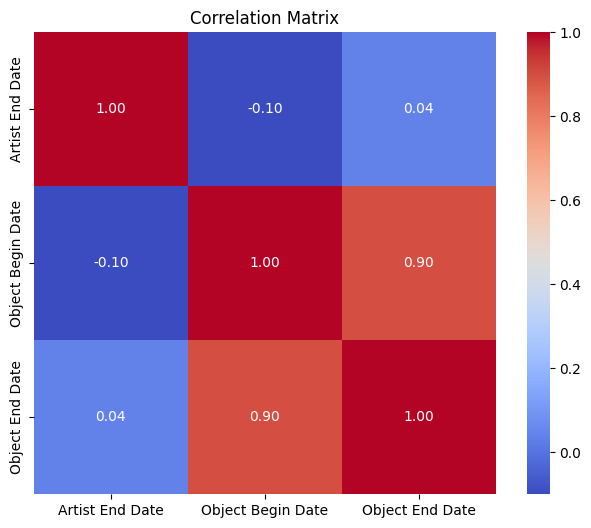

Shape of cleaned data: (314, 54)
Number of samples in features (X): 314
Number of samples in target (y): 314


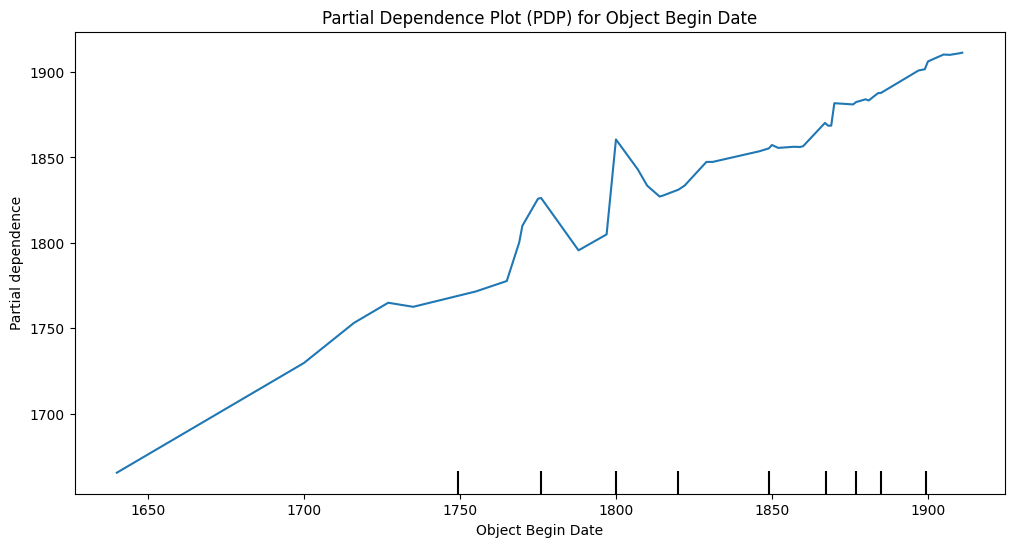

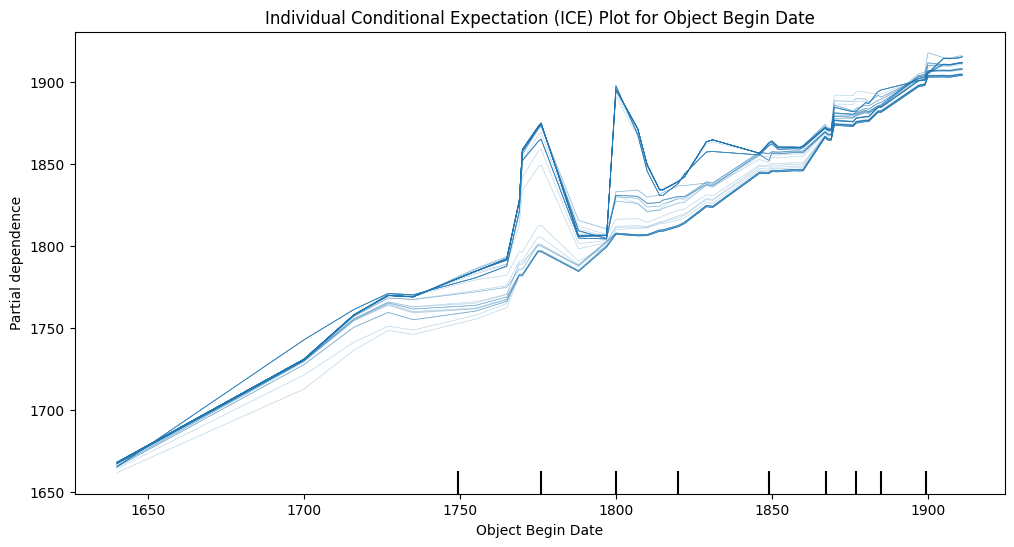

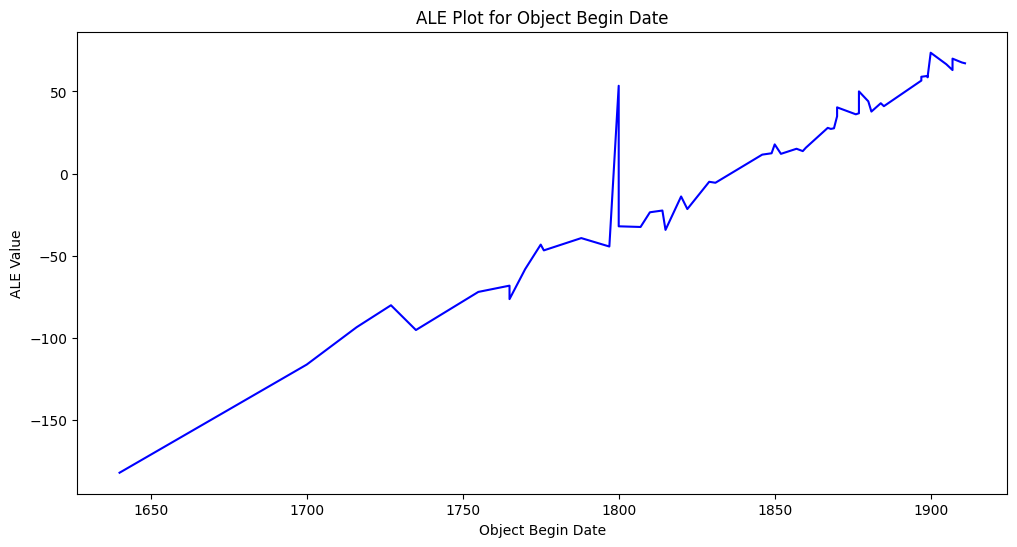

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
import numpy as np


df = pd.read_csv('/content/drive/MyDrive/MetObjects.txt')
df = df.head(1000)
df_cleaned = df.dropna(subset=['Artist End Date', 'Object Begin Date', 'Object End Date'])
df_cleaned['Artist End Date'] = pd.to_numeric(df_cleaned['Artist End Date'], errors='coerce')
df_cleaned['Object Begin Date'] = pd.to_numeric(df_cleaned['Object Begin Date'], errors='coerce')
df_cleaned['Object End Date'] = pd.to_numeric(df_cleaned['Object End Date'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Artist End Date', 'Object Begin Date', 'Object End Date'])

# Calculate the correlation matrix
correlation_matrix = df_cleaned[['Artist End Date', 'Object Begin Date', 'Object End Date']].corr()

# Display the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Define features and target variable
X = df_cleaned[['Artist End Date', 'Object Begin Date']]
y = df_cleaned['Object End Date']

# Check the shapes of the features and target
print(f"Shape of cleaned data: {df_cleaned.shape}")
print(f"Number of samples in features (X): {X.shape[0]}")
print(f"Number of samples in target (y): {y.shape[0]}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Standardize the dataset (
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Generate PDP, ICE, and ALE plots for the 'Object Begin Date' feature
feature = 'Object Begin Date'

# Partial Dependence Plot
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_test, [feature], ax=ax, kind='average')
plt.title('Partial Dependence Plot (PDP) for {}'.format(feature))
plt.show()

#ICE Plot
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_test, [feature], ax=ax, kind='individual')
plt.title('Individual Conditional Expectation (ICE) Plot for {}'.format(feature))
plt.show()

#ALE Plot
def ale_plot(model, X, feature, ax):
    # Compute the ALE values
    X_sorted = X.sort_values(feature)
    predictions = model.predict(X_sorted)
    base_prediction = model.predict(X).mean()
    ale_values = np.zeros(X_sorted.shape[0])

    for i in range(len(X_sorted)):

        ale_values[i] = predictions[i] - base_prediction

    ax.plot(X_sorted[feature], ale_values, label='ALE', color='blue')
    ax.set_title(f'ALE Plot for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('ALE Value')

fig, ax = plt.subplots(figsize=(12, 6))
ale_plot(model, X_test, feature, ax)
plt.show()


# Explanations and interesting findngs:
## 1. PDP Plot -
The general trend suggests that as the value of the Object Begin Date increases, the Object End Date also tends to increase. This shows a positive relationship. The plot starts with a relatively flat section, indicating that for lower values of the feature, the model's predictions are not very sensitive to changes in that feature. After the initial flat section, the plot shows a steep increase. This means that in this range of feature values, the model's predictions are highly influenced by changes in the feature.  Towards the higher end of the feature values, the plot starts to flatten again. This implies that for very high values of the feature, the model's predictions become less sensitive to further increases in the feature.


## 2. ICE PLOT
The ICE plot shows a lot ofvariability between the lines. In this plot, we see that the lines are quite spread out, especially towards the higher end of the feature values. This indicates that the effect of the Object Begin Date on the model's predictions is not uniform across all data points. There is considerable variability in how different data points respond to changes in this feature.

## 3. ALE PLOT
The ALE plot also shows a general increasing trend. The plot starts with a relatively flat section, indicating that for lower values of the feature, the model's predictions are not very sensitive to changes in the predictor - Object Begin Date, After the initial flat section, the plot shows a steep increase. This means that in this range of feature values, the model's predictions are highly influenced by changes in Object Begin Date. Towards the higher end of the feature values, the plot starts to flatten again. This implies that for very high values of the feature, the model's predictions become less sensitive to further increases in the feature.

## DIFFERENCE BETWEEN PDP AND ALE PLOT
The ALE plot provides a more nuanced view of the relationship, revealing potential non-linear patterns and the accumulated impact of the Object Begin Date. On the other hand, The PDP averages the model's output for each feature value, masking non-linear relationships..

## CORRELATIONS AND IMPACT ON RESULTS

'Artist End Date' shows a weak negative correlation with 'Object Begin Date' (-0.10), indicating that as the artist's end date increases, the object's begin date may slightly decrease, but the relationship is not much. In contrast, 'Object Begin Date' and 'Object End Date' are strongly positively correlated (0.90), suggesting that as the object's begin date increases, its end date tends to increase significantly as well. The correlation between 'Artist End Date' and 'Object End Date' is weakly positive (0.04), indicating a minimal relationship.

# Sources
I used Gen AI to help me with some of the coding aspects while building the model and also for debugging
